## NTK-Aware RoPE

1. 原始的 RoPE 有什么问题？
2. 外推与内插定义
4. 位置内插（PI）长文本扩展方法
5. PI 存在问题和解决方案
6. NTK-Aware RoPE
7. NTK RoPE 分析
9. 衰减性对比
10. NTK-Aware RoPE 训练

为什么需要扩展模型的 long-context 能力？

- 模型能在超长的 kv 序列中注意到关键 token
- 超长的 kv 序列中有较多噪声
- long-context kv 本身含有信息较多，latent 推理特征复杂
- long-context 对多种任务收益：math、code， 对于 code 需要访问一个超大型第三方库或工程；在agent中需要访问超过100个网页；在阅读理解中读长篇悬疑小说，推理真相
- long-context 是语言模型的基础能力，能在多个下游任务泛化。

## RoPE 缺陷

语言数据是离散时序数据， 一个词元在context中的语义表示，其相邻的 context 比较远距离文本影响重要。 

绝对位置编码，在注意力分数内积计算时，相对距离越远的 token 之间的注意力分数越小，这种特性是位置编码的衰减性。

1. 远距离注意力分数衰减不理想，将导致模型理解错误的语序。例如“我卖掉电视，买了冰箱”，如果相对位置性感知错误，则可能识别到的语义为：“我卖掉冰了箱,电买视”
2. 当context越大时（>4K)，上述现象将会更严重，强行扩展 model 的序列理解长度，将导致 PPL 爆炸
3. 从 Attention 角度理解，模型在 rope(K_{1:4k}) 是有效的。 而 rope(K_{4k~128k}) 特征诡异，导致注意力分数分配错误，影响表征。
4. rope 长度有效性，其影响因素是什么？

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
torch.manual_seed(42)

In [2]:
class RoPE(nn.Module):
    def __init__(self, dim = 512, max_pos = 4096, base = 10000.0):
        super().__init__()
        self.dim = dim
        self.base = base
        self.max_pos = max_pos
        
        m = torch.arange(0, self.max_pos, 1)
        i = torch.arange(0, self.dim//2, 1) 
        theta = self.base ** (-2 * i / self.dim)
        m_theta = torch.outer(m, theta)

        cos = torch.zeros(self.max_pos, self.dim) 
        sin = torch.zeros(self.max_pos, self.dim) 
        cos[:, 0::2] = cos[:, 1::2] = torch.cos(m_theta) # cos(theta1), cos
        sin[:, 0::2] = sin[:, 1::2] = torch.sin(m_theta) # sin, sin

        self.register_buffer('rope_cos', cos)
        self.register_buffer('rope_sin', sin)
        
    def apply_rope(self, X):
        '''
            input: X[bs, n_heads, seq_len, head_dim]
        '''
        bs, n_heads, seq_len, d = X.shape

        X_shift = torch.zeros_like(X)
        X_shift[..., 0::2] = -X[..., 1::2]
        X_shift[..., 1::2] = X[..., 0::2]

        Y = self.rope_cos[None, None, :seq_len, :] * X + \
            self.rope_sin[None, None, :seq_len, :] * X_shift

        return Y
dim = 512
seq_len = 4096
rope = RoPE(dim = dim, max_pos = 64000)

In [3]:
X = torch.ones(1, 1, seq_len, dim)
X = rope.apply_rope(X)
X = X[0,0,:,:]
# print(X[12,:])

In [4]:
result = X[0,:] @ X.t() / math.sqrt(dim)
print(result.shape)
print(result)

torch.Size([4096])
tensor([22.6274, 22.0177, 20.4826,  ...,  0.6150,  0.6347,  0.8167])


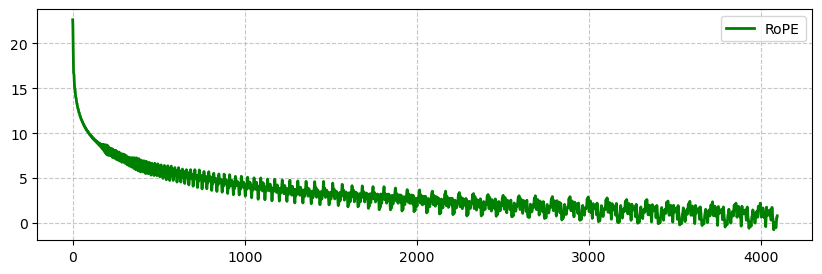

In [5]:
import matplotlib.pyplot as plt

dis = torch.arange(0, seq_len)

plt.figure(figsize=(10, 3))
plt.plot(dis.tolist(), result.tolist(), 'g', linewidth=2, label='RoPE')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

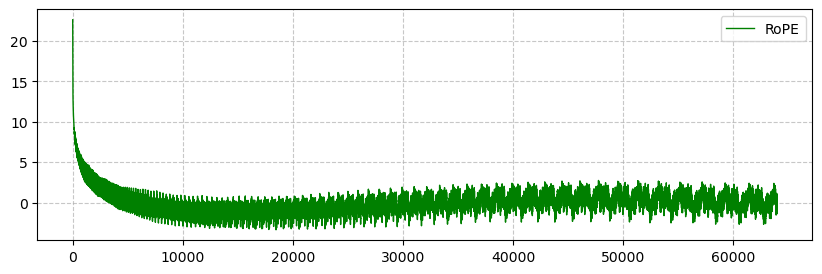

In [6]:
X = torch.ones(1, 1, 64000, dim)
X = rope.apply_rope(X)
X = X[0,0,:,:]
result = X[0,:] @ X.t() / math.sqrt(dim)
dis = torch.arange(0, 64000)
plt.figure(figsize=(10, 3))
plt.plot(dis.tolist(), result.tolist(), 'g', linewidth=1, label='RoPE')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

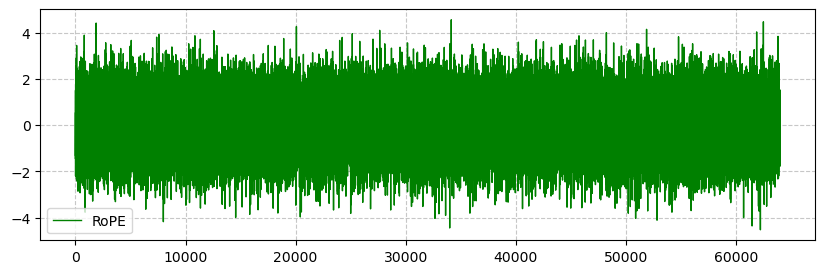

In [7]:
# 随机向量分析

Wq = torch.randn(dim,dim)
Wk = torch.randn(dim,dim)

X = torch.randn(1, 1, 64000, dim)/math.sqrt(dim)
# X = torch.ones(1, 1, 64000, dim)/math.sqrt(dim)

Q = rope.apply_rope(X@Wq)[0,0,:,:]
K = rope.apply_rope(X@Wk)[0,0,:,:]
result = Q[0,:] @ K.t() / math.sqrt(dim)
dis = torch.arange(0, 64000)
plt.figure(figsize=(10, 3))
plt.plot(dis.tolist(), result.tolist(), 'g', linewidth=1, label='RoPE')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

RoPE 小结

- 近距离衰减速率较大
- 在 4k 相对距离，呈现衰减趋势，下降不是单调的，局部震荡
- 在 64k 相对距离，可见大震荡不呈现衰减趋势了，远距离其内积值域在[-2,2] 波动
- 思考距离为负时表示了什么？ 如果 `+`值表示`[0, N>0]`位置之间的内积（右侧），`-` 实际上表示部分元素在（左侧）
- 随机向量无衰减规律，本notebook仅分析 1向量的衰减性规律

## 外推和内插定义

1. 模型预设的长度为 L, 并且在 context 长度 <L 的文本训练。 若此时在 inference 时，当输入 context > L时，测试的预测行为称为外推，即是模型在未见过的位置上进行预测，模型也未改变参数
2. 模型适应的位置编码为 $[0,1,\ldots, L-1]$, 此时在位置间插值s=2倍 $[0,0.5,1,\ldots, L-0.5, L-1]$, 即是模型在已见过位置范围，塞下更多位置编码，从而扩展模型context长度（由L->sL)

外插的问题是：

1. 外插时能否泛化？
2. 不能泛化的话，原因是什么？
3. 不能泛化的话，能否在更长的context上训练？会有什么难点？
4. 能泛化的话，是否可以训短推长？

内插的问题是：

1. 原来位置 [0,1,2] 映射成 [0,0.5,1], 位置编码的偏移了，模型是否能在新的位置编码上直接外推
2. 如果不能直接外推？能否先进行训练适配新的位置编码分布？

需要审视位置编码：

对于rope $(x_mW_qR_m)(x_nW_kR_n)^T = x_mW_qR_m R^T_n W^T_k x^T_n$ , 当 $R\rightarrow R'$, 时 $W_q,W_k$ 需要适应新的位置编码分布，所以需要进行一定的训练。问题是训练是必要的吗？（将在lecture5中讨论）

本notebook讨论的重点为RoPE改进：$R \rightarrow R'$，使得模型适应新分布（context从 L->sL），并在long-context(<sL内)推理。接下来所介绍的 PI-RoPE 和 NTK-RoPE 都无法进行严格意义的外推。

## 位置内插PI

位置内插方法为 $sin(m'\theta_i)$, $m'=m/s$。

对于一个模型最大长度为 L, 那么可以在此基础如上式修改位置编码，并进行训练（微调）

In [8]:
class PIRoPE(nn.Module):
    def __init__(self, dim = 512, scale = 2, max_pos = 4096, base = 10000.0):
        super().__init__()
        self.dim = dim
        self.base = base
        self.max_pos = max_pos
        self.scale = scale
        
        m = torch.arange(0, self.max_pos, 1) / self.scale
        i = torch.arange(0, self.dim//2, 1)
        theta = self.base ** (-2 * i / self.dim)
        m_theta = torch.outer(m, theta)

        cos = torch.zeros(self.max_pos, self.dim) 
        sin = torch.zeros(self.max_pos, self.dim) 
        cos[:, 0::2] = cos[:, 1::2] = torch.cos(m_theta) # cos(theta1), cos
        sin[:, 0::2] = sin[:, 1::2] = torch.sin(m_theta) # sin, sin

        self.register_buffer('rope_cos', cos)
        self.register_buffer('rope_sin', sin)
        
    def apply_rope(self, X):
        '''
            input: X[bs, n_heads, seq_len, head_dim]
        '''
        bs, n_heads, seq_len, d = X.shape

        X_shift = torch.zeros_like(X)
        X_shift[..., 0::2] = -X[..., 1::2]
        X_shift[..., 1::2] = X[..., 0::2]

        Y = self.rope_cos[None, None, :seq_len, :] * X + \
            self.rope_sin[None, None, :seq_len, :] * X_shift

        return Y
        
dim = 512
seq_len = 4096
max_len = 64000
rope = RoPE(dim = dim, max_pos = max_len)

s=4
pi_rope = PIRoPE(dim = dim, max_pos = max_len, scale = s)

X = torch.ones(1, 1, seq_len, dim)
X_rope = rope.apply_rope(X)

X = torch.ones(1, 1, seq_len*s, dim)
X_pi = pi_rope.apply_rope(X)
print(X_rope[0,0, 4095, :4])
print(X_pi[0,0, 8190, :4])
print(X_pi[0,0, 8191, :4])

print(X_rope[0,0, 2048, :4])
print(X_pi[0,0, 4096, :4])

tensor([ 0.9318, -1.0638,  0.7051, -1.2259])
tensor([ 1.4134, -0.0467, -1.4020,  0.1858])
tensor([ 1.3811,  0.3045, -1.4058, -0.1544])
tensor([ 1.2628,  0.6367, -1.3282, -0.4857])
tensor([ 1.1459,  0.8288, -0.7608,  1.1922])


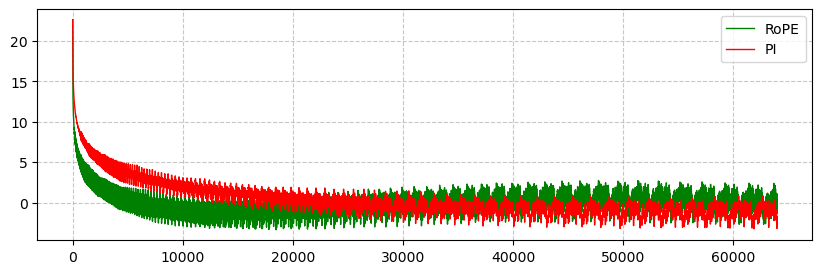

In [9]:
tmp_len = max_len
X = torch.ones(1, 1, tmp_len, dim)

X_ = rope.apply_rope(X)[0,0,:,:]
result_rope = X_[0,:] @ X_.t() / math.sqrt(dim)

X_ = pi_rope.apply_rope(X)[0,0,:,:]
result_pi = X_[0,:] @ X_.t() / math.sqrt(dim)

dis = torch.arange(0, tmp_len)
plt.figure(figsize=(10, 3))
plt.plot(dis.tolist(), result_rope.tolist(), 'g', linewidth=1, label='RoPE')
plt.plot(dis.tolist(), result_pi.tolist(), 'r', linewidth=1, label='PI')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

- PI 衰减相较 RoPE 理想
- 近距离 PI 衰减缓慢

## PI分析

- 旋转角度向量随维度序号增加，由 $1\rightarrow 0$, 左侧旋转角度更大趋近于 0，右侧趋近于 0
- 左侧（高频），右侧（低频）
- 在 rope 中，对于位置 $m$, 其角度为 $m\theta$

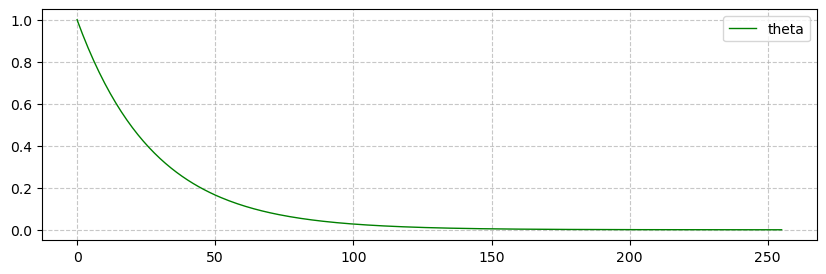

In [10]:
max_len = 4096
dim = 512
base = 10000.0
m = torch.arange(0, max_len, 1)
i = torch.arange(0, dim//2, 1)
theta = base ** (-2 * i / dim)

m_theta = torch.outer(m, theta)

plt.figure(figsize=(10, 3))
plt.plot(i.tolist(), theta.tolist(), 'g', linewidth=1, label='theta')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

随位置 m 增加，左侧高频变化更加明显

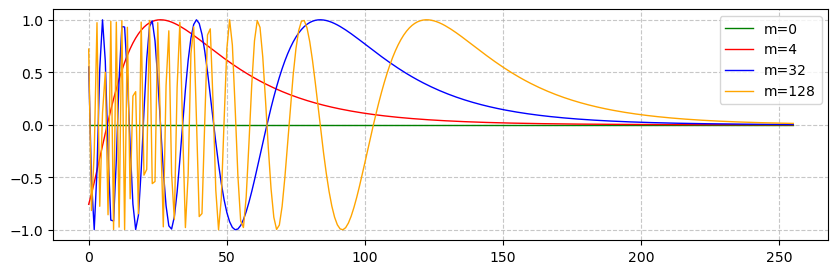

In [11]:
plt.figure(figsize=(10, 3))
plt.plot(i.tolist(), m_theta[0,:].sin().tolist(), 'g', linewidth=1, label='m=0')
plt.plot(i.tolist(), m_theta[4,:].sin().tolist(), 'r', linewidth=1, label='m=4')
plt.plot(i.tolist(), m_theta[32,:].sin().tolist(), 'b', linewidth=1, label='m=32')
plt.plot(i.tolist(), m_theta[128,:].sin().tolist(), 'orange', linewidth=1, label='m=128') 
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

- PI 相较 RoPE，数值变化较缓。
- PI 对每个维度的插值是等同的，高频特征将被大幅削减
- 特征学习时，高频是重要的
- 位置编码高频削弱了，apply_rope(x) 也对特征削弱了高频
- PI 削弱高频后，短距离的位置衰减变缓，实际上导致相邻context相关程度降低，看似能在远距离表现更好，实际破坏了预训练学好的近距离特征

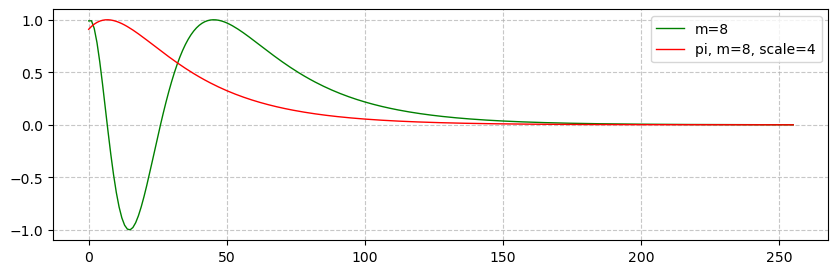

In [12]:
s = 4
m = torch.arange(0, max_len, 1)
m_pi = torch.arange(0, max_len, 1) / s
i = torch.arange(0, dim//2, 1)
theta = base ** (-2 * i / dim)

m_theta = torch.outer(m, theta)
m_pi_theta = torch.outer(m_pi, theta)

plt.figure(figsize=(10, 3))
plt.plot(i.tolist(), m_theta[8,:].sin().tolist(), 'g', linewidth=1, label='m=8')
plt.plot(i.tolist(), m_pi_theta[8,:].sin().tolist(), 'r', linewidth=1, label='pi, m=8, scale=4')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

## NTK-RoPE

PI 所有维度同等内插，其等价为

$\sin(m'\theta_i) = \sin(\frac{m}{s}\theta_i) = \sin(m\frac{\theta_i}{s}) $, $m'=m/s$。

此时，容易想到，对于高频近可能不插值，在低频上增加插值强度。

NTK-Aware RoPE 为

$$
\theta_i = \frac{1}{b'^{\frac{2(i-1)}{d}}} = \frac{1}{(sb)^{\frac{2(i-1)}{d}}} =  \frac{1}{b^{\frac{2(i-1)}{d}}} \frac{1}{s^{\frac{2(i-1)}{d}}}
$$

其中$b=10000.0$, $s>1$ 通常 $s=10.0$

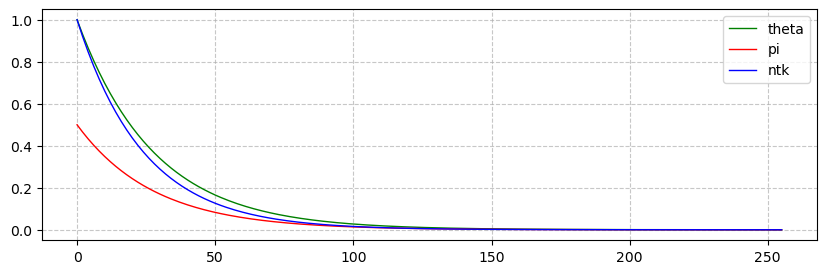

In [13]:
m = torch.arange(0, max_len, 1)
i = torch.arange(0, dim//2, 1)
s = 4
theta = base ** (-2 * i / dim)
theta_pi = base ** (-2 * i / dim) / 2
theta_ntk = (s*base) ** (-2 * i / dim)

plt.figure(figsize=(10, 3))
plt.plot(i.tolist(), theta.tolist(), 'g', linewidth=1, label='theta')
plt.plot(i.tolist(), theta_pi.tolist(), 'r', linewidth=1, label='pi')
plt.plot(i.tolist(), theta_ntk.tolist(), 'blue', linewidth=1, label='ntk')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

内插强度为：

- RoPE: $s_i = 1$
- PI: $s_i = s$
- NTK $s'_i = {s^{\frac{2(i-1)}{d}}}$

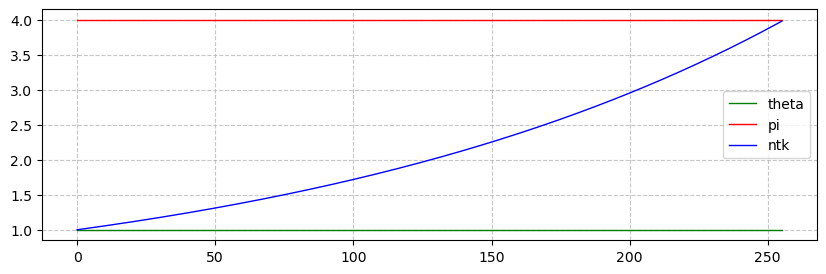

In [14]:
# 内插强度
I_rope = torch.ones(dim//2)
I_PI = torch.ones(dim//2) * s
I_NTK = (s) ** (2 * i / dim)

plt.figure(figsize=(10, 3))
plt.plot(i.tolist(), I_rope.tolist(), 'g', linewidth=1, label='theta')
plt.plot(i.tolist(), I_PI.tolist(), 'r', linewidth=1, label='pi')
plt.plot(i.tolist(), I_NTK.tolist(), 'blue', linewidth=1, label='ntk')
plt.grid(True, linestyle='--', alpha=0.7)
# plt.ylim(0,1.2)
plt.legend()
plt.show()

In [15]:
class NTKRoPE(nn.Module):
    def __init__(self, dim = 512, scale = 10.0, max_pos = 4096, base = 10000.0):
        super().__init__()
        self.dim = dim
        self.base = base * scale # scaled 
        self.max_pos = max_pos
        self.scale = scale
        
        m = torch.arange(0, self.max_pos, 1)
        i = torch.arange(0, self.dim//2, 1)
        theta = self.base ** (-2 * i / self.dim)
        m_theta = torch.outer(m, theta)

        cos = torch.zeros(self.max_pos, self.dim) 
        sin = torch.zeros(self.max_pos, self.dim) 
        cos[:, 0::2] = cos[:, 1::2] = torch.cos(m_theta) # cos(theta1), cos
        sin[:, 0::2] = sin[:, 1::2] = torch.sin(m_theta) # sin, sin

        self.register_buffer('rope_cos', cos)
        self.register_buffer('rope_sin', sin)
        
    def apply_rope(self, X):
        '''
            input: X[bs, n_heads, seq_len, head_dim]
        '''
        bs, n_heads, seq_len, d = X.shape

        X_shift = torch.zeros_like(X)
        X_shift[..., 0::2] = -X[..., 1::2]
        X_shift[..., 1::2] = X[..., 0::2]

        Y = self.rope_cos[None, None, :seq_len, :] * X + \
            self.rope_sin[None, None, :seq_len, :] * X_shift

        return Y
max_len = 64000
ntk_rope = NTKRoPE(dim = dim, max_pos = max_len, scale = 10.0)

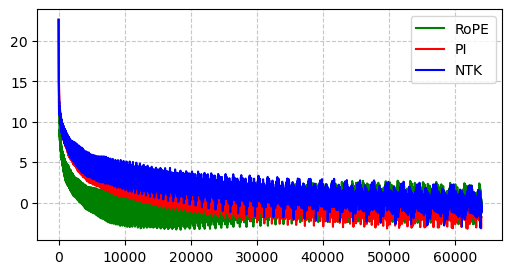

In [16]:
X_ = ntk_rope.apply_rope(X)[0,0,:,:]
result_ntk = X_[0,:] @ X_.t() / math.sqrt(dim)

dis = torch.arange(0, tmp_len)
plt.figure(figsize=(6, 3))
plt.plot(dis.tolist(), result_rope.tolist(), 'g', alpha=1,label='RoPE')
plt.plot(dis.tolist(), result_pi.tolist(), 'red', alpha=1, label='PI')
plt.plot(dis.tolist(), result_ntk.tolist(), 'blue', alpha=1, label='NTK')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

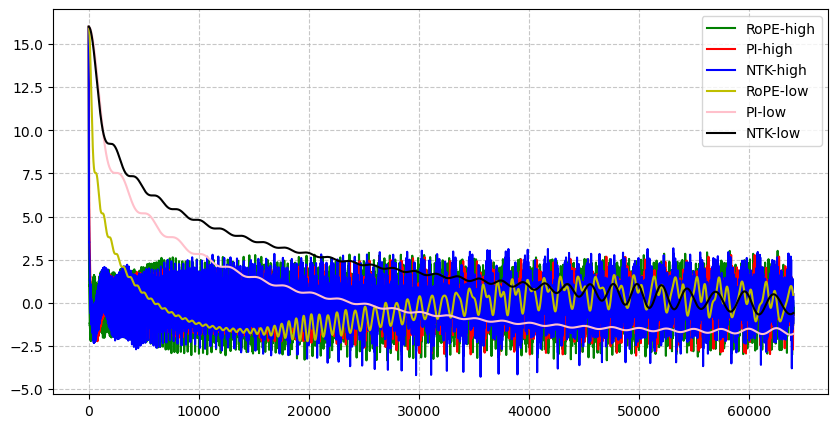

In [17]:
## 高低频衰减性分析

X_ = rope.apply_rope(X)[0,0,:,:]
result_rope_high = X_[0,:dim//2] @ X_[:,:dim//2].t() / math.sqrt(dim//2)
result_rope_low = X_[0,dim//2:] @ X_[:,dim//2:].t() / math.sqrt(dim//2)

X_ = pi_rope.apply_rope(X)[0,0,:,:]
result_pi_high = X_[0,:dim//2] @ X_[:,:dim//2].t() / math.sqrt(dim//2)
result_pi_low = X_[0,dim//2:] @ X_[:,dim//2:].t() / math.sqrt(dim//2)

X_ = ntk_rope.apply_rope(X)[0,0,:,:]
result_ntk_high = X_[0,:dim//2] @ X_[:,:dim//2].t() / math.sqrt(dim//2)
result_ntk_low = X_[0,dim//2:] @ X_[:,dim//2:].t() / math.sqrt(dim//2)

dis = torch.arange(0, tmp_len)
plt.figure(figsize=(10, 5))
plt.plot(dis.tolist(), result_rope_high.tolist(), 'g', alpha=1,label='RoPE-high')
plt.plot(dis.tolist(), result_pi_high.tolist(), 'red', alpha=1, label='PI-high')
plt.plot(dis.tolist(), result_ntk_high.tolist(), 'blue', alpha=1, label='NTK-high')

plt.plot(dis.tolist(), result_rope_low.tolist(), 'y', alpha=1,label='RoPE-low')
plt.plot(dis.tolist(), result_pi_low.tolist(), 'pink', alpha=1, label='PI-low')
plt.plot(dis.tolist(), result_ntk_low.tolist(), 'black', alpha=1, label='NTK-low')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

低频(low) 对远距离表现更佳

- 高频对近距离衰减起关键作用
- 低频对远距离衰减起关键作用，应该着重解决低频问题，从而扩展长度

在 NTK-RoPE 中，通常描述为 “高频外推、低频内插”， 实际上仅实现了后一句话，其高频也是在内插，只不过强度小。

## NTK-RoPE 训练

1. PI 用于 微调
2. NTK-RoPE 常用于继续预训练，相较 PI 好处在于每个位置都有 loss fitting
3. 在长文本扩展中，先短后长训练，Llama3，4k->8k->...多轮， DeepSeekV3 32k->128k

## 总结

1. RoPE 在远距离上衰减性不理想，直接训 long-context 困难
2. train-free 外推难度大，PI、NTK-RoPE 都要进行训练适配新位置编码
3. PI 的位置内插，导致所有角度同等缩小，影响低频
4. NTK-RoPE 缩放base，达到高频到低频，内插强度逐渐增大
6. 究竟如何保高频？